In [1]:
import sys
from glob import glob
from pathlib import Path
sys.path.append('/mnt/d/anticorr_data')
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import unique, join, Table
from scipy import signal
from scipy.stats import pearsonr
from tqdm import tqdm
import pandas as pd
from scipy.optimize import curve_fit
import statsmodels.api as sm

In [2]:
from source_names_dict import source_names_dict, source_names_w_counterparts, source_names_readable
from get_closest_srcreg import get_src_region_dict
from uvot import read_uvotsource, calc_uvot_flags, filters, filter_colors, filter_markers
from xrt import load_xrt, rename_xrt_cols, curves
from lightcurve import LightCurve

In [3]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [4]:
# Fix glob square bracket issue
to_replace = {'[':'[[]',
              ']':'[]]'}

In [5]:
def load_xrt2(simbad_name, band):
    simbad_name_glob = simbad_name.translate(str.maketrans(to_replace)) # Used to fix globbing square brackets
    csvs = glob(f'/mnt/d/anticorr_data/lightcurves/xrt/*{simbad_name_glob}*.csv')
    
    for csv in csvs:
        if 'curve_nosys' in csv:
            if band == 'FULL':
                tab = pd.read_csv(csv, dtype={'obsID':str})
                tab = Table.from_pandas(tab)
                tab.rename_column('obsID', 'OBSID')
                return tab

        if 'hardrat' in csv:
            if band == 'HARD' or band=='SOFT' or band == 'HR':
                tab = pd.read_csv(csv, dtype={'obsID':str})
                tab = tab[tab['BAND'] == band]
                tab = Table.from_pandas(tab)
                tab.rename_column('obsID', 'OBSID')
                return tab

In [6]:
# Parameters
include_bad = True
include_UL = True
simbad_name = '[LB2005]_NGC_6946_ULX1'
simbad_name = 'NAME_NGC_7793_P13'
simbad_name = '[LM2005]_NGC_4559_ULX1'


uvot_filter   = 'U'
xrt_curve     = 'HARD'

if xrt_curve == 'FULL':
    xrt_rate      = 'Rate'
    xrt_rate_err  = 'Rate_err'
else:
    xrt_rate = 'Rate'
    xrt_rate_err = 'Error'

uvot_rate     = 'COI_SRC_RATE'
uvot_rate_err = 'COI_SRC_RATE_ERR'


plot_path = Path('/mnt/d/anticorr_data/notebooks/correlation_outputs/plots/')
table_path = Path('/mnt/d/anticorr_data/notebooks/correlation_outputs/tables/')
outfile = f'{simbad_name},{xrt_curve},{uvot_filter},{include_bad},{include_UL}'


In [7]:
src_region_dict = get_src_region_dict()
local_name    = source_names_dict[simbad_name]
readable_name = source_names_readable[simbad_name]
closest_src   = src_region_dict[simbad_name]

Getting source region dict


In [8]:
# Load XRT
tab_xrt_full = load_xrt2(simbad_name, xrt_curve)
if xrt_curve == 'FULL':
    tab_xrt_full['Rate_err'] = 2 * tab_xrt_full['Ratepos']
if include_bad == False:
    print(f'include_bad = {include_bad}, filtering out BAD obs')
    print(f'len pre  = {len(tab_xrt_full)}')
    tab_xrt_full = tab_xrt_full[tab_xrt_full['BAD'] == False]
    print(f'len post = {len(tab_xrt_full)}')
if include_UL == False:
    print(f'include_bad = {include_bad}, filtering out UL obs')
    print(f'len pre  = {len(tab_xrt_full)}')
    tab_xrt_full = tab_xrt_full[tab_xrt_full['UL'] == False]
    print(f'len post = {len(tab_xrt_full)}')

In [9]:
tab_xrt_full

MJD,Err (pos),Err(neg),Rate,Error,OBSID,MODE,BAD,UL,BAND
float64,float64,float64,float64,float64,str11,str2,bool,bool,str4
56593.279392515,0.0389026967592593,-0.0389026967592593,0.009098,0.001906,00576064000,PC,False,False,HARD
56717.6255589236,1.84788232638889,-1.84788232638889,0.01652,0.002241,00032249006,PC,False,False,HARD
56721.9950569178,0.0047882407407407,-0.0047882407407407,0.016244,0.005218,00032249007,PC,False,False,HARD
58651.9546069907,0.0096925694444444,-0.0096925694444444,0.004506,0.001944,00088825001,PC,False,False,HARD
58829.040094103,0.0082125694444444,-0.0082125694444444,0.01164,0.003577,00032249008,PC,False,False,HARD
58836.5425369421,0.0078643287037037,-0.0078643287037037,0.015325,0.00391,00032249009,PC,False,False,HARD
58850.361104647,0.0052670717592592,-0.0052670717592592,0.012097,0.004356,00032249011,PC,False,False,HARD
58857.2590245185,0.0059490393518518,-0.0059490393518518,0.023856,0.006221,00032249012,PC,False,False,HARD
58864.031680588,0.0034388310185185,-0.0034388310185185,0.021747,0.007339,00032249013,PC,False,False,HARD


In [10]:
# Load UV Data
fits_files = glob(f'/mnt/d/anticorr_data/download_scripts/{local_name}/*uvotsource*fits*')
for f in fits_files:
    if closest_src.split('/')[-1][:-4] in f:
        tab_uvot = read_uvotsource(f)
tab_uvot = tab_uvot[tab_uvot['FILTER'] == uvot_filter]
tab_uvot = unique(tab_uvot, keys='OBSID')

In [11]:
tab_uvot

MET,EXTNAME,TSTART,TSTOP,EXPOSURE,TELAPSE,TIME,SRC_AREA,BKG_AREA,STD_AREA,PLATE_SCALE,RAW_TOT_CNTS,RAW_TOT_CNTS_ERR,RAW_BKG_CNTS,RAW_BKG_CNTS_ERR,RAW_STD_CNTS,RAW_STD_CNTS_ERR,RAW_TOT_RATE,RAW_TOT_RATE_ERR,RAW_BKG_RATE,RAW_BKG_RATE_ERR,RAW_STD_RATE,RAW_STD_RATE_ERR,COI_STD_FACTOR,COI_STD_FACTOR_ERR,COI_BKG_FACTOR,COI_BKG_FACTOR_ERR,COI_TOT_RATE,COI_TOT_RATE_ERR,COI_BKG_RATE,COI_BKG_RATE_ERR,COI_SRC_RATE,COI_SRC_RATE_ERR,AP_FACTOR,AP_FACTOR_ERR,AP_COI_SRC_RATE,AP_COI_SRC_RATE_ERR,LSS_FACTOR,LSS_RATE,LSS_RATE_ERR,SENSCORR_FACTOR,SENSCORR_RATE,SENSCORR_RATE_ERR,CORR_RATE,CORR_RATE_ERR,AB_MAG,AB_MAG_ERR,AB_MAG_ERR_STAT,AB_MAG_ERR_SYS,AB_MAG_BKG,AB_MAG_BKG_ERR_STAT,AB_MAG_BKG_ERR_SYS,AB_MAG_BKG_ERR,AB_MAG_LIM,AB_MAG_LIM_SIG,AB_MAG_COI_LIM,AB_FLUX_AA,AB_FLUX_AA_ERR_STAT,AB_FLUX_AA_ERR_SYS,AB_FLUX_AA_ERR,AB_FLUX_AA_BKG,AB_FLUX_AA_BKG_ERR_STAT,AB_FLUX_AA_BKG_ERR_SYS,AB_FLUX_AA_BKG_ERR,AB_FLUX_AA_LIM,AB_FLUX_AA_COI_LIM,AB_FLUX_HZ,AB_FLUX_HZ_ERR_STAT,AB_FLUX_HZ_ERR_SYS,AB_FLUX_HZ_ERR,AB_FLUX_HZ_BKG,AB_FLUX_HZ_BKG_ERR_STAT,AB_FLUX_HZ_BKG_ERR_SYS,AB_FLUX_HZ_BKG_ERR,AB_FLUX_HZ_LIM,AB_FLUX_HZ_COI_LIM,MAG,MAG_ERR,MAG_ERR_STAT,MAG_ERR_SYS,MAG_BKG,MAG_BKG_ERR_STAT,MAG_BKG_ERR_SYS,MAG_BKG_ERR,MAG_LIM,MAG_LIM_SIG,MAG_COI_LIM,FLUX_AA,FLUX_AA_ERR_STAT,FLUX_AA_ERR_SYS,FLUX_AA_ERR,FLUX_AA_BKG,FLUX_AA_BKG_ERR_STAT,FLUX_AA_BKG_ERR_SYS,FLUX_AA_BKG_ERR,FLUX_AA_LIM,FLUX_AA_COI_LIM,FLUX_HZ,FLUX_HZ_ERR_STAT,FLUX_HZ_ERR_SYS,FLUX_HZ_ERR,FLUX_HZ_BKG,FLUX_HZ_BKG_ERR_STAT,FLUX_HZ_BKG_ERR_SYS,FLUX_HZ_BKG_ERR,FLUX_HZ_LIM,FLUX_HZ_COI_LIM,COI_RATE_LIMIT,CORR_RATE_LIMIT,FILTER,RA,DEC,DETX,DETY,NSIGMA,FRAMTIME,SATURATED,SYS_ERR,SRCEXP,BKGEXP,OBSID,MJD,YEAR,MJD_0,FLAG_AB_MAG_99,FLAG_UPPER_LIM,FLAG_AB_MAG_ERR>2,FLAG_AB_MAG_>10_<30
s,,s,s,s,s,s,arcsec2,arcsec2,arcsec2,arcsec / pix,ct,ct,ct,ct,ct,ct,ct / s,ct / s,ct / (arcsec2 s),ct / (arcsec2 s),ct / s,ct / s,,,,,ct / s,ct / s,ct / (arcsec2 s),ct / (arcsec2 s),ct / s,ct / s,,,ct / s,ct / s,,ct / s,ct / s,,ct / s,ct / s,ct / s,ct / s,mag,mag,mag,mag,mag / arcsec2,mag / arcsec2,mag / arcsec2,mag / arcsec2,mag,sigma,mag,erg / (A cm2 s),erg / (A cm2 s),erg / (A cm2 s),erg / (A cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A cm2 s),erg / (A cm2 s),mjy,mjy,mjy,mjy,mjy/arcsec2,mjy/arcsec2,mjy/arcsec2,mjy/arcsec2,mjy,mjy,mag,mag,mag,mag,mag / arcsec2,mag / arcsec2,mag / arcsec2,mag / arcsec2,mag,sigma,mag,erg / (A cm2 s),erg / (A cm2 s),erg / (A cm2 s),erg / (A cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A cm2 s),erg / (A cm2 s),mjy,mjy,mjy,mjy,mjy/arcsec2,mjy/arcsec2,mjy/arcsec2,mjy/arcsec2,mjy,mjy,ct / s,ct / s,,deg,deg,pix,pix,,s,,,s,s,,s,,s,,,,
float64,bytes12,float64,float64,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float64,float64,float32,float32,float32,float32,int16,bool,float32,float32,bytes11,float64,float64,float64,bool,bool,bool,bool
348259483.36453,U,348252842.74378,348266123.98528,491.70224,13281.241,0.0,78.54662,706.8712,78.54662,1.004,1640.85,39.76675,4188.399,64.37823,1640.85,39.76675,3.3370805,0.08087567,0.012050514,0.00018522369,3.3370805,0.08087567,1.0208828,0.025203807,1.0058465,0.015540604

In [12]:
# Join Data
tab_join = join(tab_uvot, tab_xrt_full , join_type='inner', keys='OBSID')
tab_join.sort('MJD_2')

# Get x,y data
if include_UL:
    t = tab_join['MJD_2']
    
    x = tab_join[xrt_rate]
    x_err = tab_join[xrt_rate_err]
    
    y = tab_join[uvot_rate]
    y_err = tab_join[uvot_rate_err]
    
    tab_join_UL = tab_join[tab_join['UL'] == True]
    tab_join_no_UL = tab_join[tab_join['UL'] == False]
    
    t_UL = tab_join_UL['MJD_2']
    t_no_UL = tab_join_no_UL['MJD_2']
    
    x_UL = tab_join_UL[xrt_rate]
    x_UL_err = tab_join_UL[xrt_rate_err]
    
    x_no_UL = tab_join_no_UL[xrt_rate]
    x_no_UL_err = tab_join_no_UL[xrt_rate_err]
    
    y_UL = tab_join_UL[uvot_rate]
    y_UL_err = tab_join_UL[uvot_rate_err]
    
    y_no_UL = tab_join_no_UL[uvot_rate]
    y_no_UL_err = tab_join_no_UL[uvot_rate_err]
else:
    t = tab_join['MJD_2']
    
    x = tab_join[xrt_rate]
    x_err = tab_join[xrt_rate_err]
    
    y = tab_join[uvot_rate]
    y_err = tab_join[uvot_rate_err]

In [13]:
if not include_UL:
    # Caclulate pearson
    r, p_val = pearsonr(x,y)


/home/x1/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/x1/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


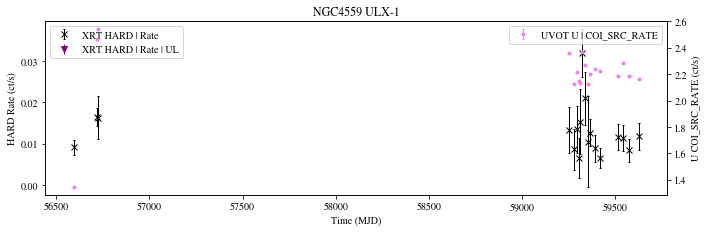

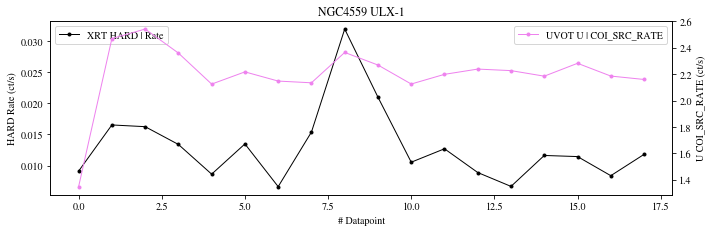

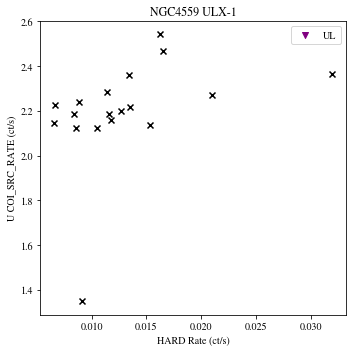

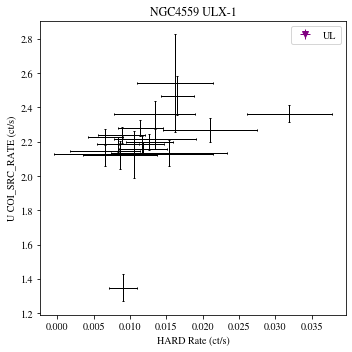

In [19]:
# Plot lightcurve
fig, ax = plt.subplots(1, 1, figsize=(10,10/3), facecolor='white')
ax2 = ax.twinx()

if include_UL:
    ax.errorbar(t_no_UL, x_no_UL, yerr=x_no_UL_err, lw=1.0, label=f'XRT {xrt_curve} | {xrt_rate}', ls='none', marker='x', color='black', capsize=1.0)
    ax.errorbar(t_UL, x_UL, yerr=(x_UL, [0]*len(x_UL)), lw=1.0, label=f'XRT {xrt_curve} | {xrt_rate} | UL', ls='none', marker='v', color='purple', capsize=1.0)
else:
    ax.errorbar(t, x, yerr=x_err, lw=1.0, label=f'XRT {xrt_curve} | {xrt_rate}', ls='none', marker='.', color='black', capsize=1.0)
    
ax2.errorbar(t, y, yerr=y_err, lw=1.0, label=f'UVOT {uvot_filter} | {uvot_rate}', ls='none', marker='.', color='violet', capsize=1.0)
ax.set_ylabel(f'{xrt_curve} {xrt_rate} (ct/s)')
ax2.set_ylabel(f'{uvot_filter} {uvot_rate} (ct/s)')
ax.set_title(readable_name)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.set_xlabel('Time (MJD)')
plt.tight_layout()
plt.savefig(plot_path/f'{outfile}_lc_mjd.png')
plt.savefig(plot_path/f'{outfile}_lc_mjd.pdf')

# Plot lightcurve (no time)
fig, ax = plt.subplots(1, 1, figsize=(10,10/3), facecolor='white')
ax2 = ax.twinx()
ax.plot(range(len(x)), x, lw=1.0, label=f'XRT {xrt_curve} | {xrt_rate}', ls='-', marker='.', color='black')
ax2.plot(range(len(y)), y, lw=1.0, label=f'UVOT {uvot_filter} | {uvot_rate}', ls='-', marker='.', color='violet')
ax.set_ylabel(f'{xrt_curve} {xrt_rate} (ct/s)')
ax2.set_ylabel(f'{uvot_filter} {uvot_rate} (ct/s)')
ax.set_title(readable_name)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.set_xlabel('# Datapoint')
plt.tight_layout()
plt.savefig(plot_path/f'{outfile},lc_seq.png')
plt.savefig(plot_path/f'{outfile},lc_seq.pdf')

# Plot correlation (No errors)
plt.figure(figsize=(5,5), facecolor='white')
if include_UL:
    plt.title(f'{readable_name}')
    plt.scatter(x_UL, y_UL, marker='v', color='purple', label='UL')
    plt.scatter(x_no_UL, y_no_UL, marker='x', color='black')
else:
    plt.scatter(x, y, marker='x', color='black')
    plt.title(f'{readable_name} | $r$ = {r:.2f}')
    
#plt.xscale('log')
#plt.yscale('log')

plt.xlabel(f'{xrt_curve} {xrt_rate} (ct/s)')
plt.ylabel(f'{uvot_filter} {uvot_rate} (ct/s)')
plt.tight_layout()
plt.legend()
plt.savefig(plot_path/f'{outfile},corr.png')
plt.savefig(plot_path/f'{outfile},corr.pdf')

# Plot Correlation with errors
plt.figure(figsize=(5,5), facecolor='white')
if include_UL:
    plt.errorbar(x_UL, y_UL, xerr=x_UL_err, yerr=y_UL_err,  lw=1.0, capsize=1.0, ls='none', color='purple', label='UL', marker='v')
    plt.errorbar(x_no_UL, y_no_UL, xerr=x_no_UL_err, yerr=y_no_UL_err,  lw=1.0, capsize=1.0, ls='none', color='black')
    plt.title(f'{readable_name}')
else:
    plt.errorbar(x, y, xerr=x_err, yerr=y_err,  lw=1.0, capsize=1.0, ls='none', color='black')
    plt.title(f'{readable_name} | $r$ = {r:.2f}')
    
plt.xlabel(f'{xrt_curve} {xrt_rate} (ct/s)')
plt.ylabel(f'{uvot_filter} {uvot_rate} (ct/s)')
plt.tight_layout()
plt.legend()
#plt.xscale('log')
#plt.yscale('log')
plt.savefig(plot_path/f'{outfile},corr_err.png')
plt.savefig(plot_path/f'{outfile},corr_err.pdf')

In [15]:
def line(x, m, c):
    return m*x+c

In [16]:
# Perform lc samplong monte carlo

all_mc_res = []
for i in tqdm(range(10000)):
    mc_res = {}
    if not include_UL:
        x_samp = np.random.normal(loc=x, scale=x_err)
        y_samp = np.random.normal(loc=y, scale=y_err)
        
    if include_UL:
        x_samp_UL = np.random.uniform(low=[0]*len(x_UL), high=x_UL)
        y_samp_UL = np.random.uniform(low=[0]*len(y_UL), high=y_UL)
        x_samp_no_UL = np.random.normal(loc=x_no_UL, scale=x_no_UL_err)
        y_samp_no_UL = np.random.normal(loc=y_no_UL, scale=y_no_UL_err)

        x_samp = np.concatenate([x_samp_UL, x_samp_no_UL])
        y_samp = np.concatenate([y_samp_UL, y_samp_no_UL])
    r, p_val = pearsonr(x_samp,y_samp)
    p_opt, p_cov = curve_fit(line, x_samp, y_samp)
    m, c = p_opt

    mc_res['r'] = r
    mc_res['m'] = m
    mc_res['c'] = c
    all_mc_res.append(mc_res)

df_mc_res = pd.DataFrame(all_mc_res)
df_mc_res.to_csv(table_path/f'{outfile},line_mc.csv', index=False)

# Calculate best fit values and errors
r_best = df_mc_res['r'].mean()
r_std  = df_mc_res['r'].std()
m_best = df_mc_res['m'].mean()
m_std  = df_mc_res['m'].std()
c_best = df_mc_res['c'].mean()
c_std  = df_mc_res['c'].std()


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1503.12it/s]


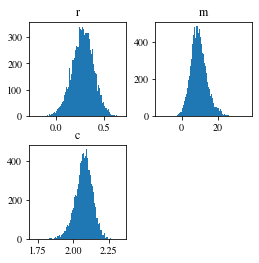

In [17]:
ax = df_mc_res.hist(bins=100, grid=False, figsize=(4.0,4.0))
plt.savefig(plot_path/f'{outfile},corr_dist.png')
plt.savefig(plot_path/f'{outfile},corr_dist.pdf')

/home/x1/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/x1/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/x1/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/x1/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/x1/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/x1/.pyenv/versions

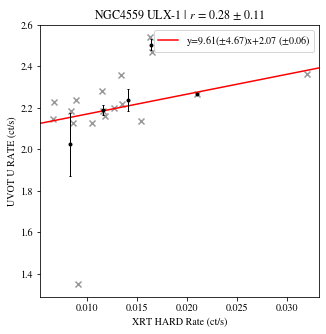

In [18]:
fig, ax = plt.subplots(1,1,figsize=(5,5), facecolor='white')
ax.scatter(x, y, marker='x', color='grey', alpha=0.8)     

xmin, xmax = ax.get_xlim()
xrange = np.linspace(xmin, xmax, 10)


# Plot best fit line
ax.plot(xrange, line(xrange, m_best, c_best), color='red', label=f'y={m_best:.2f}($\pm${m_std:.2f})x+{c_best:.2f} ($\pm${c_std:.2f})')
ax.set_xlim(xmin, xmax)
ax.legend(loc='upper right')

# Plot binned data
xmax = np.max(x)
xmin = np.min(x)
nbins = 9
xbins = np.linspace(xmin, xmax, nbins)

for i in range(nbins-1):
    xlow = xbins[i]
    xhigh = xbins[i+1]
    xs = x[(x>xlow) & (x<xhigh)]
    ys = y[(x>xlow) & (x<xhigh)]
    
    x_mean = np.mean(xs)
    x_err = np.std(xs) / np.sqrt(len(xs))
    y_mean = np.mean(ys)
    y_err = np.std(ys) / np.sqrt(len(ys))
    ax.errorbar(x_mean, y_mean, yerr=y_err, color='black', capsize=1.0, lw=1.0, marker='.', label='Binned')
    
    xmin, xmax = ax.get_xlim()
    xrange = np.linspace(xmin, xmax, 10)
    

ax.set_xlabel(f'XRT {xrt_curve} {xrt_rate} (ct/s)')
ax.set_ylabel(f'UVOT {uvot_filter} RATE (ct/s)')
ax.set_title(f'{readable_name} | $r$ = {r_best:.2f} $\pm$ {r_std:.2f}')
plt.savefig(plot_path/f'{outfile},corr_fit.png')
plt.savefig(plot_path/f'{outfile},corr_fit.pdf')